In [2]:
import json
from pathlib import Path

import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


class Food101Dataset(Dataset):
    """
    PyTorch Dataset for the Food-101 dataset.

    - Uses the official train/test splits from meta/train.json and meta/test.json
    - Returns (image_tensor, label_index) pairs
    """

    def __init__(self, df, label_to_idx=None, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with columns ['path', 'label', 'split']
            label_to_idx (dict, optional): mapping string label -> int index.
                                            If None, it is created from df['label'].
            transform (callable, optional): torchvision transforms applied to the image.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

        # Build label <-> index mapping
        if label_to_idx is None:
            unique_labels = sorted(self.df["label"].unique())
            self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        else:
            self.label_to_idx = label_to_idx

        # Reverse mapping for convenience (idx -> label string)
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = Path(row["path"])
        image = Image.open(img_path).convert("RGB")

        # Map label string -> integer class index
        label_str = row["label"]
        label_idx = self.label_to_idx[label_str]

        if self.transform is not None:
            image = self.transform(image)

        return image, label_idx


def build_food101_dataframe(root_dir):
    """
    Build a single pandas DataFrame with columns:
    - 'path' : full path to image file
    - 'label': class name (e.g. 'apple_pie')
    - 'split': 'train' or 'test'

    It uses the official Food-101 meta files train.json and test.json.

    Args:
        root_dir (str or Path): path to the root of the food-101 dataset
                                (the folder that contains 'images' and 'meta').

    Returns:
        pd.DataFrame
    """
    root_dir = Path(root_dir)
    images_dir = root_dir / "images"
    meta_dir = root_dir / "meta"

    # Load the JSON split files
    with open(meta_dir / "train.json", "r") as f:
        train_dict = json.load(f)

    with open(meta_dir / "test.json", "r") as f:
        test_dict = json.load(f)

    rows = []

    # Each JSON is: { "class_name": ["class_name/img1", "class_name/img2", ...], ... }
    # We'll expand into one row per image.
    for label, img_list in train_dict.items():
        for rel_path in img_list:
            img_path = images_dir / f"{rel_path}.jpg"  # rel_path is like 'apple_pie/12345'
            rows.append(
                {
                    "path": str(img_path),
                    "label": label,
                    "split": "train",
                }
            )

    for label, img_list in test_dict.items():
        for rel_path in img_list:
            img_path = images_dir / f"{rel_path}.jpg"
            rows.append(
                {
                    "path": str(img_path),
                    "label": label,
                    "split": "test",
                }
            )

    df = pd.DataFrame(rows)
    return df


if __name__ == "__main__":
    # ====== CHANGE THIS PATH TO YOUR ACTUAL DATA LOCATION ======
    DATA_ROOT = Path("/kaggle/input/tabemono/food-101")  # adjust if running from another folder

    # 1. Build the DataFrame
    df = build_food101_dataframe(DATA_ROOT)
    print("Total images:", len(df))
    print(df.head())

    # 2. Quick sanity checks
    print("\nClass count:", df["label"].nunique())
    print("Split distribution:\n", df["split"].value_counts())

    # 3. Define simple transforms (will refine later for training)
    transform = T.Compose(
        [
            T.Resize((224, 224)),
            T.ToTensor(),
        ]
    )

    # 4. Build train / test datasets
    df_train = df[df["split"] == "train"].reset_index(drop=True)
    df_test = df[df["split"] == "test"].reset_index(drop=True)

    # Use the same label_to_idx for both train and test
    dataset_train = Food101Dataset(df_train, transform=transform)
    dataset_test = Food101Dataset(df_test, label_to_idx=dataset_train.label_to_idx, transform=transform)

    # 5. Wrap in DataLoader and inspect a batch
    train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)

    batch_imgs, batch_labels = next(iter(train_loader))
    print("\nBatch image tensor shape:", batch_imgs.shape)   # [B, C, H, W]
    print("Batch labels shape:", batch_labels.shape)
    print("Example label indices:", batch_labels[:10].tolist())
    print("Index 0 label string:", dataset_train.idx_to_label[batch_labels[0].item()])


Total images: 101000
                                                path    label  split
0  /kaggle/input/tabemono/food-101/images/churros...  churros  train
1  /kaggle/input/tabemono/food-101/images/churros...  churros  train
2  /kaggle/input/tabemono/food-101/images/churros...  churros  train
3  /kaggle/input/tabemono/food-101/images/churros...  churros  train
4  /kaggle/input/tabemono/food-101/images/churros...  churros  train

Class count: 101
Split distribution:
 split
train    75750
test     25250
Name: count, dtype: int64

Batch image tensor shape: torch.Size([16, 3, 224, 224])
Batch labels shape: torch.Size([16])
Example label indices: [29, 47, 99, 28, 48, 69, 99, 10, 99, 90]
Index 0 label string: cup_cakes


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

# ====== PATHS FOR KAGGLE ======
DATA_ROOT = "/kaggle/input/tabemono/food-101"

# ====== BUILD DATAFRAME ======
df = build_food101_dataframe(DATA_ROOT)

# Split
df_train = df[df["split"] == "train"].reset_index(drop=True)
df_test = df[df["split"] == "test"].reset_index(drop=True)

# ====== DATA TRANSFORMS ======
transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

transform_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# ====== DATASETS ======
dataset_train = Food101Dataset(df_train, transform=transform_train)
dataset_test = Food101Dataset(df_test, label_to_idx=dataset_train.label_to_idx, transform=transform_test)

# ====== DATALOADERS ======
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4)

# ====== MODEL ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset_train.label_to_idx))
model = model.to(device)

# ====== LOSS + OPTIMIZER ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ====== TRAIN LOOP ======
def train_epoch():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total

# ====== TEST LOOP ======
def test_epoch():
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return correct / total

# ====== RUN TRAINING ======
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch()
    test_acc = test_epoch()
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s] 
100%|██████████| 1184/1184 [13:38<00:00,  1.45it/s]


Epoch 1/3 | Loss: 1.6277 | Train Acc: 0.6088 | Test Acc: 0.7963


100%|██████████| 1184/1184 [13:46<00:00,  1.43it/s]


Epoch 2/3 | Loss: 0.7214 | Train Acc: 0.8063 | Test Acc: 0.8318


100%|██████████| 1184/1184 [13:47<00:00,  1.43it/s]


Epoch 3/3 | Loss: 0.4668 | Train Acc: 0.8735 | Test Acc: 0.8338


In [9]:
import torch
from PIL import Image as PILImage
import torchvision.transforms as T

# Use test transforms (no augmentation)
inference_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def predict_image(image_path, topk=5):
    model.eval()
    img = PILImage.open(image_path).convert("RGB")
    img = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
        top_probs, top_idxs = probs.topk(topk)

    top_probs = top_probs.cpu().numpy()[0]
    top_idxs = top_idxs.cpu().numpy()[0]

    results = []
    for prob, idx in zip(top_probs, top_idxs):
        label = dataset_train.idx_to_label[idx]
        results.append((label, float(prob)))

    return results


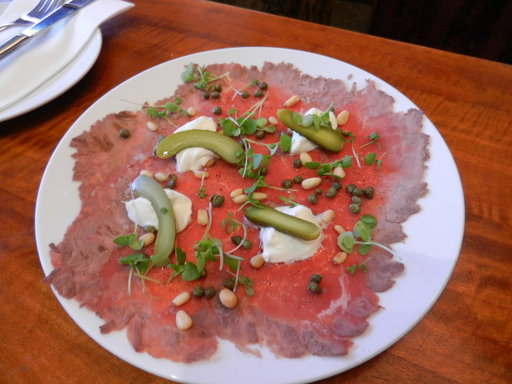

[('beef_carpaccio', 0.9984288811683655), ('huevos_rancheros', 0.0007142036338336766), ('prime_rib', 0.00030288068228401244), ('tuna_tartare', 0.0001887327089207247), ('beef_tartare', 0.00016028646496124566)]


In [10]:
from kaggle_secrets import UserSecretsClient
from IPython.display import Image, display
import os

uploaded_path = "/kaggle/input/tabemono/food-101/images/beef_carpaccio/1011469.jpg"

# Upload using sidebar (Kaggle built-in uploader)
display(Image(filename=uploaded_path))
print(predict_image(uploaded_path))


In [11]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np

# Same preprocessing as inference
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict_multi_item(image_path, grid_size=3, threshold=0.2):
    """
    Splits the image into grid crops, classifies each crop,
    returns aggregated food predictions.
    """
    model.eval()
    img = Image.open(image_path).convert("RGB")
    w, h = img.size
    
    patch_w = w // grid_size
    patch_h = h // grid_size
    
    predictions = []
    
    for row in range(grid_size):
        for col in range(grid_size):
            # Crop region
            left = col * patch_w
            upper = row * patch_h
            right = left + patch_w
            lower = upper + patch_h
            
            patch = img.crop((left, upper, right, lower))
            patch_tensor = transform(patch).unsqueeze(0).to(device)
            
            with torch.no_grad():
                outputs = model(patch_tensor)
                probs = torch.softmax(outputs, dim=1)
                top_prob, top_idx = probs.topk(1)
                
            top_prob = float(top_prob.cpu().numpy()[0][0])
            top_idx = int(top_idx.cpu().numpy()[0][0])
            label = dataset_train.idx_to_label[top_idx]
            
            if top_prob >= threshold:
                predictions.append(label)
    
    # Count occurrences
    from collections import Counter
    return Counter(predictions)


In [13]:
image_path = "/kaggle/input/tabemono/food-101/images/pad_thai/1011059.jpg"
result = predict_multi_item(image_path, grid_size=3, threshold=0.25)
print(result)


Counter({'panna_cotta': 1, 'poutine': 1, 'tacos': 1, 'bread_pudding': 1})


In [17]:
!pip install ultralytics



image 1/1 /kaggle/input/tabemono/food-101/images/ramen/1000325.jpg: 640x640 1 broccoli, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


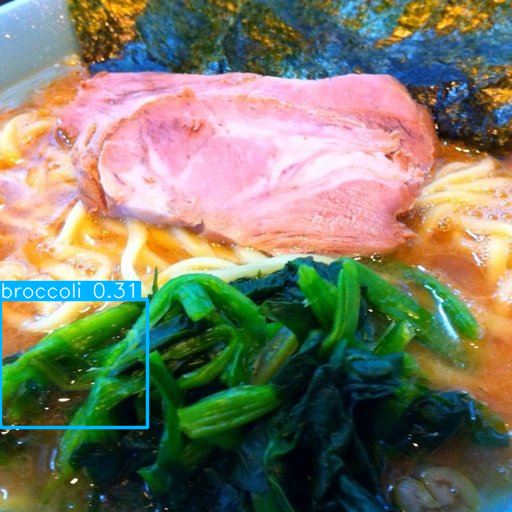

[('pho', 0.5507143139839172)]


In [18]:
from ultralytics import YOLO
import cv2
from PIL import Image # Need PIL.Image

# Define the image path used for detection
image_path = "/kaggle/input/tabemono/food-101/images/ramen/1000325.jpg" 

# Load a pretrained YOLO model (general objects)
yolo_model = YOLO("yolov8n.pt") # small + fast

# Run detection
results = yolo_model(image_path)
results[0].show()

# --- FIX IS HERE ---
# 1. Load the original image into the variable 'img'
img = Image.open(image_path).convert("RGB") 
# --- END FIX ---

boxes = results[0].boxes.xyxy.cpu().numpy()

multi_food_output = []

for (x1, y1, x2, y2) in boxes:
    # Now 'img' is defined and the .crop() method can be called
    crop = img.crop((x1, y1, x2, y2)) 
    crop_tensor = inference_transform(crop).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(crop_tensor)
        prob = torch.softmax(out, dim=1)
        top_prob, top_idx = prob.topk(1)

    label = dataset_train.idx_to_label[int(top_idx)]
    multi_food_output.append((label, float(top_prob)))

print(multi_food_output)

In [19]:
!pip install ultralytics open_clip_torch

In [20]:
import torch
from ultralytics import YOLO
import open_clip
from PIL import Image
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- YOLO: object detector ---------
# small, fast model; good for prototyping
yolo_model = YOLO("yolov8n.pt")  


# --------- CLIP: open-vocabulary classifier ---------
clip_model, clip_preprocess, _ = open_clip.create_model_and_transforms(
    "ViT-B-32", 
    pretrained="laion2b_s34b_b79k"   # big LAION pretraining, good for food
)
clip_model = clip_model.to(device)
clip_model.eval()
tokenizer = open_clip.get_tokenizer("ViT-B-32")


# --------- Build label space for CLIP ---------
# 1) All Food-101 classes
data_root = Path("/kaggle/input/tabemono/food-101")
classes_file = data_root / "meta" / "classes.txt"

food101_labels = []
with open(classes_file, "r") as f:
    for line in f:
        food101_labels.append(line.strip())

# 2) Extra foods beyond Food-101 (you can edit / extend this list)
extra_food_labels = [
    "idli", "dosa", "sambar", "rasam", "dal", "chapati", "paratha",
    "biryani", "fried rice", "curry", "paneer curry", "chicken curry",
    "rice with curry", "thali", "poha", "upma", "vada", "pav bhaji",
    "maggi noodles", "masala dosa", "butter chicken", "gulab jamun"
]

clip_labels = food101_labels + extra_food_labels

print("Total CLIP label vocabulary size:", len(clip_labels))

# --------- Precompute CLIP text embeddings ---------
with torch.no_grad():
    text_tokens = tokenizer([f"a photo of {c}" for c in clip_labels]).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

import torch.nn.functional as F

def clip_classify_pil(pil_img, topk=3):
    """
    Classify a PIL image crop using CLIP over the label set `clip_labels`.
    Returns list of (label, prob).
    """
    img = clip_preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(img)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # similarity: [1, D] @ [N, D]^T -> [1, N]
        logits = 100.0 * image_features @ text_features.T
        probs = logits.softmax(dim=-1)  # convert to probabilities

    probs = probs.cpu()[0]
    top_probs, top_idxs = torch.topk(probs, k=topk)

    results = []
    for p, idx in zip(top_probs, top_idxs):
        label = clip_labels[int(idx)]
        results.append((label, float(p)))
    return results


def detect_multi_food_yolo_clip(image_path, yolo_conf=0.25, clip_topk=3, min_clip_prob=0.15):
    """
    Full pipeline:
    - Run YOLO to find object regions
    - For each region, run CLIP classification over `clip_labels`
    - Keep top-1 CLIP label if prob >= min_clip_prob
    Returns: list of dicts with bbox + label + prob.
    """
    img = Image.open(image_path).convert("RGB")
    w, h = img.size

    # 1. YOLO inference
    results = yolo_model.predict(source=image_path, conf=yolo_conf, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy()   # [N, 4]
    confidences = results[0].boxes.conf.cpu().numpy()  # YOLO objectness

    detections = []

    for (x1, y1, x2, y2), obj_conf in zip(boxes, confidences):
        # crop the region
        crop = img.crop((x1, y1, x2, y2))

        # 2. CLIP classification on crop
        clip_preds = clip_classify_pil(crop, topk=clip_topk)
        top_label, top_prob = clip_preds[0]

        if top_prob >= min_clip_prob:
            detections.append({
                "bbox": [float(x1), float(y1), float(x2), float(y2)],
                "yolo_conf": float(obj_conf),
                "label": top_label,
                "clip_prob": float(top_prob),
                "clip_topk": clip_preds  # keep all topk for debugging
            })

    return detections


test_image = "/kaggle/input/tabemono/food-101/images/beef_carpaccio/1011469.jpg"

detections = detect_multi_food_yolo_clip(test_image, yolo_conf=0.25, clip_topk=3, min_clip_prob=0.15)

for d in detections:
    print(f"Box: {d['bbox']}")
    print(f"  Label: {d['label']} (CLIP prob ~ {d['clip_prob']:.3f}, YOLO conf {d['yolo_conf']:.3f})")
    print(f"  Top-k: {d['clip_topk']}")
    print()


Total CLIP label vocabulary size: 123
Box: [1.5879395008087158, 0.06669922173023224, 509.6901550292969, 384.0]
  Label: beef_carpaccio (CLIP prob ~ 1.000, YOLO conf 0.768)
  Top-k: [('beef_carpaccio', 0.9996169805526733), ('tuna_tartare', 0.00026424703537486494), ('beef_tartare', 8.925693691708148e-05)]

Box: [48.85537338256836, 57.44404220581055, 451.9726257324219, 371.35986328125]
  Label: beef_carpaccio (CLIP prob ~ 1.000, YOLO conf 0.722)
  Top-k: [('beef_carpaccio', 0.9997913241386414), ('tuna_tartare', 0.0001660934794927016), ('beef_tartare', 2.1924704924458638e-05)]

Box: [0.14259643852710724, 0.24695435166358948, 68.84725189208984, 57.7770881652832]
  Label: french_fries (CLIP prob ~ 0.283, YOLO conf 0.546)
  Top-k: [('french_fries', 0.2831927239894867), ('frozen_yogurt', 0.10878018289804459), ('steak', 0.06659054011106491)]

Box: [0.4667724668979645, 0.0, 96.46173095703125, 59.10061264038086]
  Label: french_fries (CLIP prob ~ 0.195, YOLO conf 0.397)
  Top-k: [('french_fries',

In [35]:
def estimate_calories_final(detections, image_path, calorie_db, DB_PATH, avg_serving_g=200):
    img = Image.open(image_path)
    w, h = img.size
    img_area = w * h
    
    results = []
    total_cal = 0
    
    for det in detections:
        label = det["label"]

        # 🔥 Handle unknown foods
        if label not in calorie_db:
            print(f"\n⚠ New food detected: {label}")
            cal = float(input(f"Enter calories per 100g for '{label}': "))

            # update dict
            calorie_db[label] = cal
            
            # persist to CSV
            new_entry = pd.DataFrame([[label, cal]], columns=["food", "calories_per_100g"])
            new_entry.to_csv(DB_PATH, mode='a', header=False, index=False)

            print(f"✔ Added '{label}' → {cal} kcal/100g to database.")

        # continue calorie calculation
        x1, y1, x2, y2 = det["bbox"]
        bbox_area = (x2 - x1) * (y2 - y1)

        portion_ratio = bbox_area / img_area
        portion_g = portion_ratio * avg_serving_g
        
        calories = (portion_g / 100) * calorie_db[label]
        total_cal += calories

        results.append({
            "label": label,
            "portion_g": portion_g,
            "calories": calories
        })

    return results, total_cal


In [36]:
import pandas as pd

calorie_df = pd.read_csv("/kaggle/input/calorie-estimator/calorie_db.csv")  # ← adjust path if needed
calorie_db = dict(zip(calorie_df.food, calorie_df.calories_per_100g))

print("Loaded", len(calorie_db), "food entries.")


Loaded 50 food entries.


In [37]:
test_image = "/kaggle/input/test-image/test_image.jpg"
DB_PATH = "/kaggle/working/calorie_db.csv"

# Step 1: Detect foods
detections = detect_multi_food_yolo_clip(test_image)

# Step 2: Estimate calories
calorie_results, total_cal = estimate_calories_final(
    detections=detections,
    image_path=image_path,
    calorie_db=calorie_db,
    DB_PATH=DB_PATH
)

# Step 3: Display results
print("\n=== 🥗 NUTRIVISION CALORIE REPORT ===\n")
for r in calorie_results:
    print(f"{r['label'].title():<20} → {r['calories']:.2f} kcal  ({r['portion_g']:.1f}g)")

print("\n-------------------------------------")
print(f"Total Estimated Calories: {total_cal:.2f} kcal")
print("-------------------------------------")



⚠ New food detected: garlic_bread


Enter calories per 100g for 'garlic_bread':  12


✔ Added 'garlic_bread' → 12.0 kcal/100g to database.

⚠ New food detected: takoyaki


Enter calories per 100g for 'takoyaki':  13


✔ Added 'takoyaki' → 13.0 kcal/100g to database.

⚠ New food detected: seaweed_salad


Enter calories per 100g for 'seaweed_salad':  15


✔ Added 'seaweed_salad' → 15.0 kcal/100g to database.

⚠ New food detected: bruschetta


Enter calories per 100g for 'bruschetta':  18


✔ Added 'bruschetta' → 18.0 kcal/100g to database.

⚠ New food detected: caesar_salad


Enter calories per 100g for 'caesar_salad':  25


✔ Added 'caesar_salad' → 25.0 kcal/100g to database.

⚠ New food detected: carrot_cake


Enter calories per 100g for 'carrot_cake':  34


✔ Added 'carrot_cake' → 34.0 kcal/100g to database.

⚠ New food detected: clam_chowder


Enter calories per 100g for 'clam_chowder':  45


✔ Added 'clam_chowder' → 45.0 kcal/100g to database.

=== 🥗 NUTRIVISION CALORIE REPORT ===

Garlic_Bread         → 18.42 kcal  (153.5g)
Takoyaki             → 10.71 kcal  (82.3g)
Omelette             → 153.42 kcal  (99.6g)
Seaweed_Salad        → 3.60 kcal  (24.0g)
Seaweed_Salad        → 2.56 kcal  (17.0g)
Seaweed_Salad        → 2.48 kcal  (16.5g)
Bruschetta           → 306.26 kcal  (1701.4g)
Caesar_Salad         → 144.23 kcal  (576.9g)
Seaweed_Salad        → 2.66 kcal  (17.7g)
Carrot_Cake          → 2.24 kcal  (6.6g)
Seaweed_Salad        → 1.96 kcal  (13.1g)
Clam_Chowder         → 33.19 kcal  (73.8g)
Paratha              → 197.00 kcal  (75.8g)

-------------------------------------
Total Estimated Calories: 878.74 kcal
-------------------------------------
